# Introduction

In [part 1](./supervised-learning-part-1.ipynb) of this tutorial we reviewed how supervised learning algorithms use **labeled data** to learn how to solve a problem.  We also went over the goals of supervised learning algorithmis - specifically the minimization of the **loss function** that seeks to concurently drive down both fitting error - so that the function $f(\mathbf{x})$ closely tracks the labels $Y$ associated with the set of features in $\mathbf{x}$ - and model complexity.

We then covered supervised learning algorithms that produce **linear decision boundaries** allowing them to solve linearly seperable problems, and introduced the **kernel trick**, a method to enable these algorithms to accomodate problems that are not linearly seperable.

In this part of the tutorial we will cover algorithms that naturally produce **non-linear decision** boundaries and are well-suited to solve complex problems with solutions that are not linearly seperable.

## Labeled Data

As in the first part of the tutorial, we'll need to first load our data set, and then split it into a training set and a test set.

In [1]:
from IPython.display import display
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline
import pandas as pd

np.random.seed(5000) #for reproducibility
rnd_state = 5000 #for reproducibility 



dat = pd.read_csv('data/abalone.csv')  #Read in the data
dat['Age'] = dat['Rings'] + 1.5  #Age is defined as the number of rings in the shell + 1.5
dat['AgeClass'] = 0
dat['AgeClass'][dat.Age > 11] = 1

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [2]:
dat.head()

,Sex,Length_mm,Diameter_mm,Height_mm,WholeWeight_g,ShuckedWeight_g,VisceraWeight_g,ShellWeight_g,Rings,Age,AgeClass
0,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,8.5,0
1,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,10.5,0
2,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,11.5,1
3,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,8.5,0
4,I,0.425,0.300,0.095,0.3515,0.1410,0.0775,0.120,8,9.5,0


In [124]:
#   Metadata - 
#   Source:  http://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.names
#
#   Name                Data Type   Units   Description
#   ----                ---------   -----   -----------
#   Sex                 nominal             M, F, and I (infant)
#   Length              continuous  mm      Longest shell measurement
#   Diameter            continuous  mm      perpendicular to length
#   Height              continuous  mm      with meat in shell
#   Whole weight        continuous  grams   whole abalone
#   Shucked weight      continuous  grams   weight of meat
#   Viscera weight      continuous  grams   gut weight (after bleeding)
#   Shell weight        continuous  grams   after being dried
#   Rings               integer             +1.5 gives the age in years

In [4]:
#Let's rename the columns so they are easier to work with
dat.columns=['Sex', 'Length', 'Diameter', 'Height', 'WholeWeight', 'ShuckedWeight', 
         'VisceraWeight', 'ShellWeight', 'Rings', 'Age', 'AgeClass']

Next we will split the data set into the features, $\mathbf{x}$, and the labels, $Y$.

In [5]:
x = dat[['Sex', 'Length', 'Diameter', 'Height', 'WholeWeight', 'ShuckedWeight', 
         'VisceraWeight', 'ShellWeight', 'Rings']]
Y = dat[['Age', 'AgeClass']]

In [6]:
display(x.head())
display(Y.head())

,Sex,Length,Diameter,Height,WholeWeight,ShuckedWeight,VisceraWeight,ShellWeight,Rings
0,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
1,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
2,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
3,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7
4,I,0.425,0.300,0.095,0.3515,0.1410,0.0775,0.120,8


,Age,AgeClass
0,8.5,0
1,10.5,0
2,11.5,1
3,8.5,0
4,9.5,0


## Train / Test Data Split

We will use the features in $\mathbf{x}$ to train a series of supervised algorithms to learn how these features map to the labels in $Y$.  In order to be able to test how the algorithms perform, we'll need two sets of data, one that the algorithms are trained on, and one that the algorithms have not seen.  So we'll first begin by splitting our data into two sets - a training set containing 75% of the data, and a test set containing 25% of the data.

In [7]:
from sklearn.cross_validation import train_test_split
x_train, x_test, Y_train, Y_test = train_test_split(x, Y, test_size=0.25, 
                                                    random_state=rnd_state)
x_train.reset_index(drop=True, inplace=True)
x_test.reset_index(drop=True, inplace=True)
Y_train.reset_index(drop=True, inplace=True)
Y_test.reset_index(drop=True, inplace=True)

We will also create one-hot encoded dummy variables for our categorical feature, the details of which are covered in the Part 1 of the tutorial.  And we'll create another set of Age bins with 3 classes to solve multiclass classification problems. 

In [ ]:
sex_dummies = pd.get_dummies(x_test['Sex'])
x_test[['F','M','I']] = sex_dummies[['F','M','I']]

sex_dummies = pd.get_dummies(x_train['Sex'])
x_train[['F','M','I']] = sex_dummies[['F','M','I']]
x_train[['Sex','F','M','I']].head(10)

In [ ]:
feature_names = ['M', 'F', 'I', 'Length', 'Diameter', 'Height', 'WholeWeight', 'ShuckedWeight', 'VisceraWeight',
                'ShellWeight']

In [ ]:
#We'll 3 age classes like in Part 1 of the tutorial so we can solve
#multiclass classification problems
Y_train['AgeClassMulti'] = 0
Y_train['AgeClassMulti'][((Y_train.Age > 10) & (Y_train.Age <= 12))] = 1
Y_train['AgeClassMulti'][Y_train.Age > 12] = 2

Y_test['AgeClassMulti'] = 0
Y_test['AgeClassMulti'][((Y_test.Age > 10) & (Y_test.Age <= 12))] = 1
Y_test['AgeClassMulti'][Y_test.Age > 12] = 2

We will also define a few functions to allow us to easily evaluate performance of the different algorithmis we will review.

In [186]:
#Model evaluation functions

from sklearn.metrics import confusion_matrix, mean_squared_error
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    cm_norm = np.round(100.*cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 1)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, str(cm[i, j]) + ' (' + str(cm_norm[i, j]) + '%)',
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    
def eval_classifier(Y_pred, Y_test, score, class_names):
    
    print('Percent of correct classifications = ' + str(round(100*score, 2)))


    cnf_matrix = confusion_matrix(Y_test, Y_pred);


    plt.rcParams['figure.figsize'] = [16, 6]

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=False,
                          title='Confusion matrix')

    

def eval_regressor(Y_pred, Y_test, Y_predTr, Y_train):
    
    plt.scatter(Y_pred, Y_test, label = 'Data')
    plt.plot([np.min(Y_pred), np.max(Y_pred)], [np.min(Y_pred), np.max(Y_pred)],
            linestyle = 'dashed', color = 'black', linewidth = 3, label = 'Unity Line')
    plt.legend(loc = 2)
    plt.xlabel('Predicted Values')
    plt.ylabel('Actual Values')
    plt.show();
    
    print('RMSE Test = ' + str(np.sqrt(mean_squared_error(Y_pred, Y_test))))
    print('RMSE Train = ' + str(np.sqrt(mean_squared_error(Y_predTr, Y_train))))
    
np.set_printoptions(precision=2)

# Supervised Learning Algorithms - Part 2

## Naive Bayes

Naive Bayes is a probabilistic method for classification.  Unlike previous classifiers we discussed, Naive Bayes is not limited to producing linear decision boundaries, though its decision boundaries are constrained as we'll discuss below.  This method is only suitable for classification problems and does not accomodate regression problems.

Intuitively, the approach Naive Bayes takes to classify a snail into an age group category is to ask, given the observed values of each of the $\mathbf{x}$ features this snail has, which of the possible classes is the most probable class of the snail?  Another way to think about it is to imagine a simple 2D feature space with dimensions $X1$ and $X2$, in a two-class classification problem.  Next, imagine a probability distribution on this space that tells us the probability of Class 1 (the height of the distribution) for each location on the feature space.  We also have a second distribution like this for Class 2.  At each location on the feature space, one of the two distributions will have a higher amplitude (a higher probability), and this is the class we will select for any snail with those features.

<img src="images/naive_bayes.png">

More explicitly for our multiclass snail example, we have 3 classes for age, 'Young', 'Middle Age', and 'Old'.  For a given set of physical parameters such as sex, height, weight, etc, we will compute 3 values:

1.  Probability of the snail being 'Young', $P_y$
2.  Probability of the snail being 'Middle Age', $P_m$
3.  Probability of the snail being 'Old', $P_o$

We will then simply select the largest of these probabilities to determine that snail's class.

Let's first try to compute the probability of a snail's class being 'Young', $C_y$, given a set of values for the physical features in $\mathbf{x}$.  We can denote this conditional probability $P(C_y | x_1, x_2, ..., x_n)$.  To be more concise we'll simplify the notation further by putting all of $x_1$ through $x_n$ into the notation $\mathbf{x}$.  Our working notation for the probability of a snail being 'Young' given a set of features is then $P(C_y | \mathbf{x})$.  

To compute this probability we can use Bayes Theorem.  Bayes theorem says that:

$$P(A | B) = \frac{P(B | A)P(A)}{P(B)}$$

so we can compute this for each of our age classes.

For 'Young' snails:

$$P(C_y | \mathbf{x}) = \frac{P(\mathbf{x} | C_y)P(C_y)}{P(\mathbf{x})}$$

For 'Middle Age' snails: 

$$P(C_m | \mathbf{x}) = \frac{P(\mathbf{x} | C_m)P(C_m)}{P(\mathbf{x})}$$

For 'Old' snails:

$$P(C_o | \mathbf{x}) = \frac{P(\mathbf{x} | C_o)P(C_o)}{P(\mathbf{x})}$$

Recall that we are trying to determine which of these 3 probabilities is the highest, given a set of $\mathbf{x}$.  Because the denominator, $P(\mathbf{x})$ does not depend on the class, it only scales the conditional probabilities for each class by the same amount and can therefore not change which of them is the largest.  We can therefore ignore it and just compute the numerator, and the largest numerator will correspond to the largest conditional probability.

Next, the Naive Bayes approach makes the assumption that features are independent of each other in determining the class.  For example, the contribution of a snail's *Weight* to the probability for a given class is independent of the contribution of its *Length*.  With this assumption we can rewrite the numerator, for example for the age group 'Young', as the following:

$$P(\mathbf{x} | C_y)P(C_y) = [P(x_1 | C_y)P(x_2 | C_y)...P(x_n|C_y)]P(C_y)$$

and similarly for the other classes.  

We're done!  This can trivially be computed from the training data itself.  To compute P(C_y) we simply compute the proportion of snails that are young in the training data.  That takes care of the term on the right.  We can also easily compute the term on the left in square brackets.  For example, for $x_1 = height$, $P(height | C_y)$ can be computed by taking all of the snails in the training data that are 'Young' and computing their height distribution.  Then, for a new snail, we can just plug in its height to this distribution and get back $P(height | C_y)$.  We can similarly do this for all other $P(x_1 | C_y)$ to $P(x_n | C_y)$.  Finally, we can repeat this process for the other classes for 'Middle Age' and 'Old' snails.  

With these values we can now take a new snail, and quickly compute the class that has the highest probability, conditional on the snail's physical features.  Our classification model is complete.

Note that the method we relied on above to compute the conditional class probabilities cannot actually be used for continuous features like height.  For example, we may have a lot of 'Old' snails with $height = x_1$ and $height = x_1 + 0.001$ but no 'Old' snails with $height = x_1 + 0.1$.  Yet, it's still very likely that if we get a new snail with that height, it is an 'Old' snail.  More generally, if we really precisely measure height, since it's continuous, there will only be either one or zero snails that have this height for any of the classes.  In other words, the method we used above to compute conditional probabilities assumes discrete features with **multinomial** or **binomial** distributions and fails for continuous features.  One solution is to discretize our continuous features into bins, and if the bins are an appropriate width, we're ok and we can proceed with the method.

A better approach though is to fit continous distributions, often taken to be a Gaussian distributions, to how the snails of each class are distributed on the feature space (see figure above for a two-class example).  This method is often referred to as **Gaussian Naive Bayes**, and can handle continuous features unlike **Binomial** and **Multinomial** Naive Bayes which can only handle binary and categorical features, respectively.  Unlike the Binomial and Multinomial Naive Bayes decision boundaries, the decision boundary for Gaussian Naive Bayes is **not** linear, but is instead **quasi-quadratic or parabolic**, and is formed by the location where the different class distributions intersect, as can be seen in the figure.

Rather than computing all of this from scratch, we can rely on sklearn's Naive Bayes implementation, which has a variety of additional options to tailor it to a data set, and makes implementation of a Naive Bayes classifier very simple. 

In [151]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(x_train[feature_names], Y_train['AgeClassMulti'].to_frame())

/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GaussianNB()

As we've done before, we can evaluate our classification model by looking at the percentage of correct classifications and at the confusion matrix.

Percent of correct classifications = 58.52


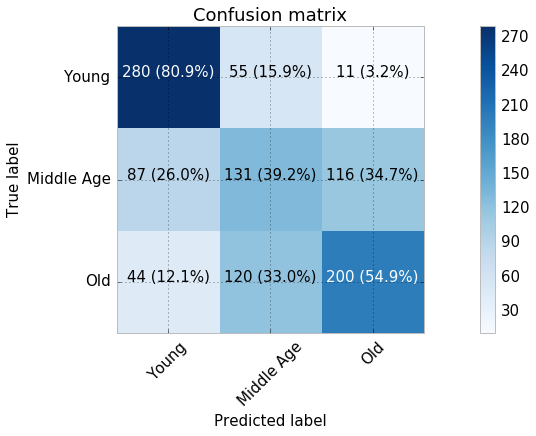

In [152]:
class_names = ['Young', 'Middle Age', 'Old']
score = model.score(x_test[feature_names], Y_test['AgeClassMulti'])
Y_pred = model.predict(x_test[feature_names])

eval_classifier(Y_pred, Y_test['AgeClassMulti'], score, class_names)

The classifier performed at 58.52% accuracy and failed to classify 'Old' snails correctly compared to other models.  Still, this percentage is significantly higher than chance (33.3%) and this algorithm is highly scalable compared to all other algorithms.  Furthermore, its performance can be improved by tweaking various hyperparameters, but these topics are beyond the scope of this introductory overview.

## k Nearest Neighbors

k Nearest Neighbors (kNN) is a very simple algorithm that can be used both for classification and for regression.  Its decision boundary for classification is also non-linear and it naturally supports multiclass classification.  The algorithm works by simply storing all of the training data and comparing each new sample whose $Y$ needs to be determined to this training data.  To do the comparison, a parameter $k$ is first set.  This parameter determines the number of neighboring data points from the training set that will be used to determine a new sample's $Y$ estimate.

For example, let's consider an example from our snail data set with only 2 features, *Height* and *WholeWeight*.  We can first make a scatterplot of this data, shown below.

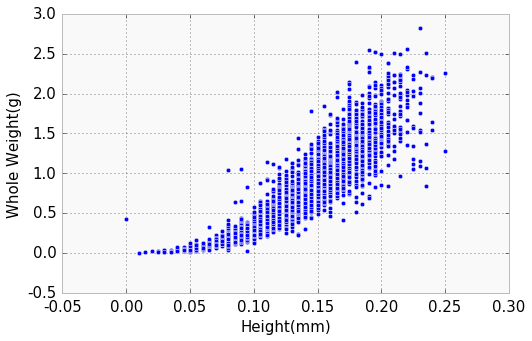

In [34]:
plt.rcParams['figure.figsize'] = [8,5]
plt.scatter(x_train['Height'], x_train['WholeWeight'])
plt.xlabel('Height(mm)')
plt.ylabel('Whole Weight(g)')
plt.xlim(-0.05, 0.3);

For each snail in our test set we would first use its *Weight* and *Height* to place the snail in the feature space depicted above.  We would then select the $k$ closest points in this feature space.  Next use the *Age* of the snails these $k$ points correspond to in order to determine the *Age* of the test snail.  For classification, we assign the age group that is most frequent in the $k$ closest snails to the new test snail.  For regression, we assign the average of the snails' ages as the age of this test snail.  

Selecting $k$ can be critical in getting good classifications and regression values.  

In addition, distance in the feature space, which determines which $k$ snails are closest, can be measured in a number of different ways, each best suited to different types of data.  

These considerations are not covered in this introductory overview, though typically such hyperparameters can be optimized with validation methods.

Next we will implement a kNN regressor and a kNN classifier using our full feature space.  Although our full feature space is higher dimensional than the *Height* and *Whole Weight* example above, computing distances is identical.  

## Regression

In [197]:
from sklearn.neighbors import KNeighborsRegressor
model = KNeighborsRegressor(n_neighbors=10)
model.fit(x_train[feature_names], Y_train['Age'])

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_neighbors=10, p=2, weights='uniform')

In [ ]:
plt.rcParams['figure.figsize'] = [16, 6]
plt.rcParams['font.size'] = 15

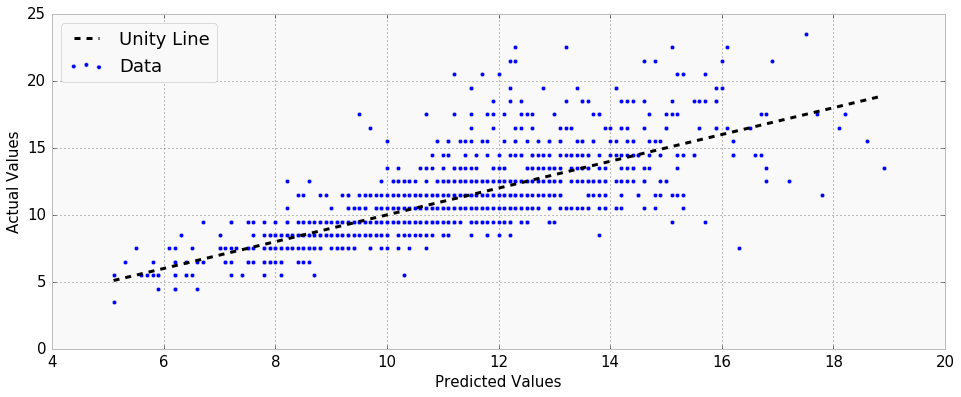

RMSE Test = 2.13585519046
RMSE Train = 2.0162763626


In [198]:
Y_pred = model.predict(x_test[feature_names])
Y_predTr = model.predict(x_train[feature_names])

eval_regressor(Y_pred, Y_test['Age'], Y_predTr, Y_train['Age'])

## Classification

In [155]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=10)
model.fit(x_train[feature_names], Y_train['AgeClassMulti'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=10, p=2, weights='uniform')

Percent of correct classifications = 63.6


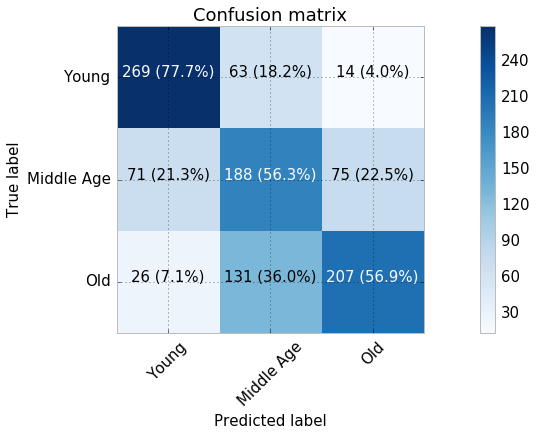

In [156]:
class_names = ['Young', 'Middle Age', 'Old']
score = model.score(x_test[feature_names], Y_test['AgeClassMulti'])
Y_pred = model.predict(x_test[feature_names])

eval_classifier(Y_pred, Y_test['AgeClassMulti'], score, class_names)

For classification, we see that for this data and this set of hyperparameters, the kNN classifier performed comparably with other models, with 63.6% accuracy.

## Decision Tree Models

Decision Tree models are a set of algorithms that subdivide a feature space by placing a series of binary decision boundaries on the space.  The following figure shows an example of a schematic decision tree that classifies snails into young and old.

<img src="images/dec_tree.png" width="500">

The tree depicted in the figure above classifies all snails that weigh more than 2g as 'Old'.  If a snail is less than 2g, the tree checks its length feature.  If that feature is less than 0.5mm, the snail is classified as 'Young'.  Otherwise, the tree once again checks the snail's weight, this time if it's greater than or less than 1, and thus completes the classification.  Decision trees select their splits based on some type of information theoretic metric such as **entropy** or **Gini index**.  Intuitively, the trees try to determine where to place a split such that the two resulting groups have maximally different classes, and classes within the groups are maximally similar.  For example, when trying to split 10 snails into two groups, a split that creates two groups, one with 4 'Old' and 1 'Young' snail, and another group with 1 'Old' and 4 'Young' snails may be less favored than a split that produces a group with 5 'Old' snails and 1 'Young' snail, and anoter group that produces 4 'Young' snails.  The specific metric used depends on whether the problem is a classification problem or a regression problem, but in both cases the intuitive idea is the same.

Decision trees themselves are not great for modeling data for a number of reasons, not the least of which is that they can easily overfit data.  Furthermore, a small change in the training data can have a very big effect on the decision tree.  For example, if the first split in the figure above is changed due to a small change in the data, all subsequent splits can also be affected.

Although decision trees are not generally great classifiers by themselves, they are often used as building blocks for more robust machine learning algorithms including Random Forests and Gradient Boosted trees.  Both of these algorithms rely on shallow decision trees (trees with only a few splits) that weakly model the data.  By ensembling many weak decision trees learners together, these algorithms can produce very robust predictions. 

## Random Forests 
**(Needs some visuals, about split selections, etc)**

The first ensemble tree method we'll cover in this overview is the Random Forest model.  Random forests can be used both for classifcation and for regression and produce non-linear decision boundaries.  Simply put, a random forest is a collection of shallow (few splits) decision trees.  For each tree, a small number of the features a snail has are randomly selected, and the decision tree is built with only those features.  In addition, the training data set is resampled with replacement, or bootstrapped, so that each tree sees a different but "equally likely to occur" set of data.  Because not all features and not all snails are used for any given tree, each tree will learn a different part of the feature space and be exposed to different noise fluctuations.  

After training, snails can be presented to the forest for prediction.  For example, in a classification task, each tree will produce a prediction on whether a snail is 'Young' or 'Old', and each individual tree on its own will only perform slightly better than random guessing across the many snails it may try to classify.  For a given single snail, each tree 'votes' on the class in which it thinks the snail should be classified.  Then, these votes are aggregated, and the class with the most votes is assigned to the snail.  Although the predictions of individual trees is poor, the combined prediction of the whole forest as determined by the votes of all trees can be very accurate.

This approach naturally avoids overfitting and is also robust to small changes in the training data because small changes will only affect a small and insignificant number of the trees in the Random Forest.

We now show how to implement a Random Forest classifier and Regressor using sklearn.

### Classification

In [157]:
from sklearn.ensemble import RandomForestClassifier

# Let's make a random forest with 1000 decision trees
# We use 'gini' criterion, suitable for classification tasks
# We'll ask each tree to only make 7 splits to avoid overfitting
model = RandomForestClassifier(n_estimators=1000, criterion='gini', 
                               max_depth = 7, random_state = rnd_state)

In [158]:
model.fit(x_train[feature_names], Y_train['AgeClassMulti'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=5000, verbose=0,
            warm_start=False)

Percent of correct classifications = 65.61


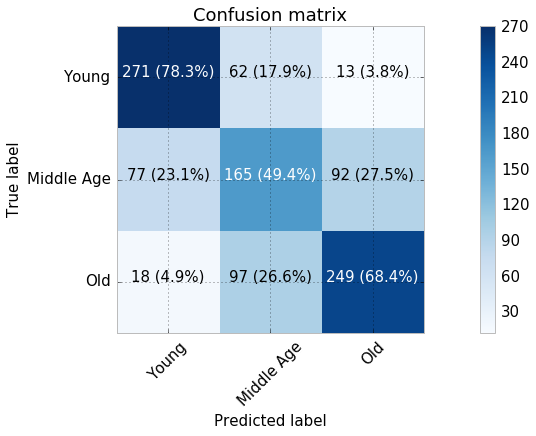

In [159]:
class_names = ['Young', 'Middle Age', 'Old']
score = model.score(x_test[feature_names], Y_test['AgeClassMulti'])
Y_pred = model.predict(x_test[feature_names])

eval_classifier(Y_pred, Y_test['AgeClassMulti'], score, class_names)

### Regression

Extending random forests to regression is very natural.  Whereas for classification each tree votes on a class and the class with the most votes wins, for regression each tree makes a prediction about the age of a snail, and the final prediction is the average age.

In [199]:
from sklearn.ensemble import RandomForestRegressor

# We'll now implement a random forest for regression
# We'll use mean squared error as our split criterion
# We'll ask each tree tree to make only 7 splits to avoid overfitting
model = RandomForestRegressor(n_estimators=1000, criterion='mse', 
                              max_depth = 7, random_state = rnd_state)

In [200]:
model.fit(x_train[feature_names], Y_train['Age'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=1, oob_score=False, random_state=5000,
           verbose=0, warm_start=False)

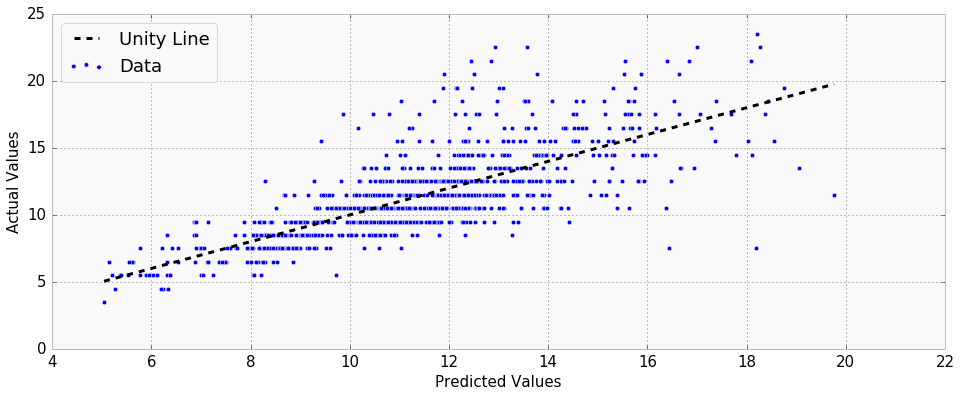

RMSE Test = 2.06722276708
RMSE Train = 1.78301393281


In [201]:
Y_pred = model.predict(x_test[feature_names])
Y_predTr = model.predict(x_train[feature_names])

eval_regressor(Y_pred, Y_test['Age'], Y_predTr, Y_train['Age'])

## Gradient Boosting and Gradient Boosted Trees

Another way that multiple weak decision tree learners can be put togehter to create a more robust prediction is through a method called Gradient Boosting.  Gradient Boosting is a method that can be used with numerous algorithms.  Intuitively speaking, it is a method that fits simple functions or weak learners to data sequentially.  Data points that are misclassified or poorly fit by previously applied functions or learers are more strongly weighted and influence the next function or learner that is applied more strongly than data points that are correctly classified or well-fit.

Let's consider first the case of fitting a series of simple functions to data by looking at the figures below.  The left panel shows data to which a simple step function has been fit.  Not surprisingly, it's not a very good fit.  We can improve the fit by first computing the residuals, shown in the panel on the right.  That is, we subtract the function from each data point to compute the simple function's fit error for each point, shown in green.  Then, we can fit another simple function to the residuals.

<img src="images/boosting_function1.png" width="500">

Next we can add the two functions together.  Note that because we are adding the functions together, any part of the residual-fitted function that closely follows residuals that have values near 0 adds values near 0 to the final result, thereby not changing it by much.  But parts of the residual-fitted function that follows residuals away from 0 have a large effect on the overall result.  In other words, each subsequent fit of the simple function puts more weight on poorly fitted data points.  We can see the result in the left panel in the figure below.  The resulting function is now a slightly better fit.  The panel on the right again shows the residuals, and we again fit these new residuals with another simple function.

<img src="images/boosting_function2.png" width="500">

If we repeat this process enough times, our resulting fit gets better and better, as seen in the figure below.

<img src="images/boosting_function3.png">

This method is called gradient boosting because it is related to **gradient descent**, a method by which we move along the gradient of a model's error in such a way as to minimize the error.

Now that we have an intuitive understanding of gradient boosting, we can see how we can apply this to decision trees.  Like the simple step function we used above, we'll use a very simple decision tree with only a single split.  Our strategy will be similar to the simple function example as well.  That is, we will fit a series of simple trees sequentially, and each time weigh data points that were misclassified more strongly to encourage the trees to make sure to classify those points correctly.  The figure below shows a 2-dimensional feature space in the leftmost panel and data points with two classes, represented by '$+$' and '$-$'.  We first apply our single-split decision tree, shown in the second panel, which classifies the two '$+$' on the left correctly, and all of the '$-$' correctly.  But 3 '$+$' data points that have been circled are incorrectly classified.  The third panel depicts the data points that were incorrectly classified by the first decision tree as bigger, indicating that the next tree we fit will more strongly weight those points to make sure it correctly classifies them, at the expense of misclassifying other points.  This is similar to residual fitting we previously discussed in that errors are more strongly weighted to drive subsequent fits.  Because the 3 data points now drive the decision tree's split more strongly, they are correctly classified in the fourth panel.  However, some '$-$' data points (circled) that were classified correctly previously are now misclassified.  The fifth panel now depicts these data points as larger, indicating they will be weighted more strongly by the next decision tree we apply, shown in the 6th panel.  

<img src="images/boosting_trees.png">

We continue this process training many of these weak decision tree learners.  When we're done we simply combine them into the full ensemble, weighing each learner's contribution to the combined model prediction by how many points it classified correctly.  Like with random forests, the prediction of the combined model is much more robust than the predictions of the weak classifiers that make it up.

We now implement Gradient Boosted Tree classification and regression.

### Classification

In [202]:
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(n_estimators = 1000, max_depth = 1, 
                                   random_state = rnd_state)

In [203]:
model.fit(x_train[feature_names], Y_train['AgeClassMulti'])

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=1, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              random_state=5000, subsample=1.0, verbose=0,
              warm_start=False)

Percent of correct classifications = 63.6


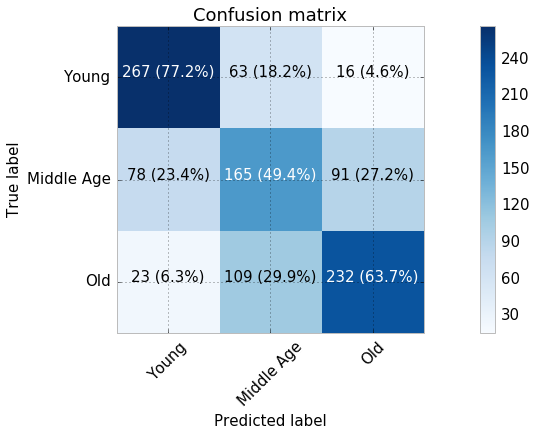

In [165]:
class_names = ['Young', 'Middle Age', 'Old']
score = model.score(x_test[feature_names], Y_test['AgeClassMulti'])
Y_pred = model.predict(x_test[feature_names])

eval_classifier(Y_pred, Y_test['AgeClassMulti'], score, class_names)

### Regression

In [204]:
from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor(n_estimators = 1000, max_depth = 1, 
                                  random_state = rnd_state)

In [205]:
model.fit(x_train[feature_names], Y_train['Age'])

GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.1, loss='ls',
             max_depth=1, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=1000,
             random_state=5000, subsample=1.0, verbose=0, warm_start=False)

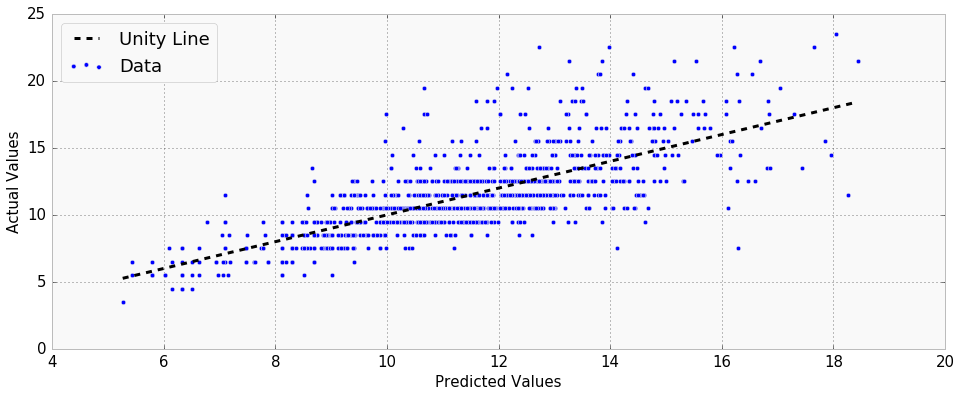

RMSE Test = 2.08684057539
RMSE Train = 2.11587141025


In [206]:
Y_pred = model.predict(x_test[feature_names])
Y_predTr = model.predict(x_train[feature_names])

eval_regressor(Y_pred, Y_test['Age'], Y_predTr, Y_train['Age'])

## Neural Networks

Neural networks are a highly flexible class of algorithms that can tackle a large array of classification and regression problems.  These algorithms are great at extracting most types of patterns, but carry a hefty computational cost compared to other algorithms and also require very large training data sets to trully perform well.

Neural networks come in a wide variety of architectures.  Recurrent neural networks can be used for time series or sequential problems.  Convolutional networks can be used for image processing and feature extraction.  Deep neural net architectures have accomplished incredible feats, such as defeating the world champion at the game of Go.

The simplest neural network is called a perceptron and has two layers of neurons.  Perceptrons have linear decision boundaries and therefore cannot solve linearly inseperable problems.  The simplest neural network that supports non-linear decision boundaries and can solve linearly inseperable problems is a three layer feedforward network.

<img src="images/neural_network.png" width="500">

The network shown above has three layers.  The first layer is called the input layer, where the features like snail height and snail weight come in.  The values of these featuers set the 'activity' $a_k$ of each neuron $k$.  Neurons in this layer are connected to a second layer called the hidden layer.  The activity of each neuron, $i$, in the hidden layer, $a_i$ is a weighted sum of the input layer neurons.  That is:

$$a_i = f(\sum_{k}{w_{ki}a_k})$$

where $w_{ki}$ is the weight between input neuron $k$ and hidden neuron $i$ and $f()$ is an **activation function** - typically an S-shaped function such as the logistic function we encountered in Logistic Regression, the hyperbolic tangent function, $tanh$, or a number of others -  that is used to put bounds on the possible values $a_i$ can take. 

The activity, $a_j$ of each output neuron $j$ is similarly defined:

$$a_j = f(\sum_{i}{w_{ij}a_i})$$

Whenever an Abalone snail is presented to the network's input layer, input layer activity, which encodes the snail's features, drives hidden layer activity, which in turn output layer activity, and that output activity encodes the age or age group of the snail. 

Because weights in the network are randomly initialized, before a network is trained, any snail's features presented to the input layer will drive a random pattern of activity in the output layer and therefore produce a random value for age.  So the first order of business is to train the network to be able to determine a snail's age from its features.  

Conceptually, our goal is to adjust or fit the weights, $w_{ki}$ and $w_{ij}$ so that we get activity that encodes the correct age in the output layer for every snail's features we enter.  This sounds more difficult and daunting than it actually is, but because it is mathematically heavy, we will not show the derivation in this overview.  Intuitively, for every snail we present to the input layer, we get a predicted age, even if that predicted age is wrong.  The difference between this prediction and the actual true age is the error of the network, $E$.  It is possible to compute the gradient of $E$ with respect to $w_{ki}$ and $w_{ij}$.  Because these quantities, $\frac{\partial E}{\partial w_{ki}}$ and $\frac{\partial E}{\partial w_{ij}}$ are essentially slopes of the surface of the error function with respect to the weights, they tell us how we need to change the weights in order to make $E$ smaller - in other words in order to decrease the error, a method known as **gradient descent**.  The strategy then becomes to sequentially present different snails from the training set to the network, and based on the prediction error for each snail, iteratively adjust the weights to decrease that error.  After repeating this process many times over, the network is able to correctly predict the age of new snails.

Neural networks are very computationally intensive and rely on multidimensional array computations.  The Theano module allows us to build efficient neural networks, and can easily utilize GPU processing to speed up computations.  TensorFlow is another more recent and very fast backend that can be used instead.  Because neural networks often require much more tuning than other algorithms, using Theano or TensorFlow to define custom networks and architectures can often be useful.  However, for many applications the module Keras, which can run on top of either Theano or TensorFlow, can make neural network implementation much faster.  We will build a simple network in Keras to show its useage.

## Classification

In [51]:
#!sudo pip install git+https://github.com/fchollet/keras.git --upgrade
#!sudo pip install theano
#!sudo pip install numpy --upgrade
#!sudo pip uninstall six -y
#!sudo pip install six --upgrade
#!sudo pip install tensorflow

In [169]:
import os
os.environ['KERAS_BACKEND'] = 'theano' #use theano backend
from keras.models import Sequential  #This allows us to build a network layer by layer
from keras.layers import Dense #Dense layers are fully connected neural network layers

In [170]:
#Define the model as a 'Sequential' model, allowing us to add layers one at a time
model = Sequential()

# Add the input layer.  This layer will have 25 neurons
# input_dim is the number of features we have for our snails
# init defines how weights should be initialized (uniform random)
# and activation sets our activation function, for which we'll use the ReLU function
model.add(Dense(25, input_dim=len(feature_names), init='uniform', activation='relu'))

#We'll add the hidden layer now, it has 50 neurons
model.add(Dense(50, init='uniform', activation='relu'))

# Finally, we'll add the output layer and give that 3 neurons
# Rather than returning a class, the model will return 3 probabilities
# Since we have 3 classes, 'Young', 'Middle Age', and 'Old'
# We need 3 output neurons to have the 3 probability outputs.
model.add(Dense(3, init='uniform', activation='sigmoid'))

In [171]:
# Let's compile all the layer definitions into a model

# loss is the Error function - sparse_categorical_crossentropy is for categorical error
# this is because our categories are encoded as integers.  If categories are one-hot encoded
# then the correct loss function is categorical_crossentropy

# optimizer is the method by which we find the minimum error, adam is very efficient

# we also want the model to return the 'accuracy' as the measure of interest
# which is what we're used to, percentage of correctly classified snails

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', 
              metrics=['accuracy'])

In [172]:
# Fit the model
# nb_epoch is how many times does the network go through each of the snails in the training set
# the larger this is, the better the network will learn.
# batch_size is the number of snails the network sees at once.  If it's large, we can't move around the
# error function space as finely.  If it's small, training takes longer.
# we'll set it to 3 to get good accuracy and decent speed
model.fit(np.array(x_train[feature_names]), y = np.array(Y_train['AgeClassMulti']).reshape((-1,1)), 
          nb_epoch=500, batch_size=3, verbose = 0)

Percent of correct classifications = 68.97


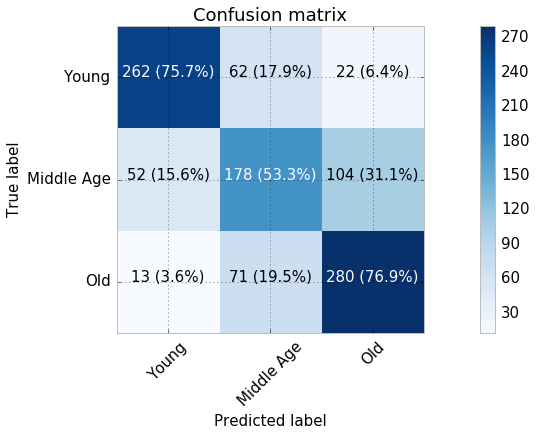

In [56]:
class_names = ['Young', 'Middle Age', 'Old']
Y_pred = model.predict_classes(np.array(x_test[feature_names]), verbose = 0)
score = model.evaluate(np.array(x_test[feature_names]), 
                       np.array(Y_test['AgeClassMulti']).reshape((-1,1)), verbose = 0)[1]

eval_classifier(Y_pred, Y_test['AgeClassMulti'], score, class_names)

## Regression

We will now build a network to demonstrate regression.  The network will be very similar to the classification network, with some minor changes to its output layer, to have a single neuron since each snail will get a single predicted value for Age.  We also need to change the activation function of the output layer activation function to linear because unlike classification, where the output is probabilities for each class that are bounded between 0 and 1, regression values for age should be unbounded (or bounded to physically realistic values).  If we do not change the activation function the network will never be able to produce an age greater than 1, and will therefore never perform well.  Finally, we should give the network some more neurons since regression is a more difficult problem than classification, and to compensate for the slow computation with more neurons, we'll increase the batch size a bit.

In [207]:
model = Sequential()
model.add(Dense(100, input_dim=len(feature_names), init='uniform', activation='relu'))
model.add(Dense(100, init='uniform', activation='relu'))
model.add(Dense(1, init='uniform', activation='linear'))

# let's set loss to 'mse', mean squared error, for regression
# let's also try a different optimizer
# we don't need a metric this time, the square root of the mse is what we've been using
# for other models
model.compile(loss='mse', optimizer='rmsprop')

In [208]:
model.fit(np.array(x_train[feature_names]), y = np.array(Y_train['Age']),
          nb_epoch=500, batch_size=5,  verbose = 0)

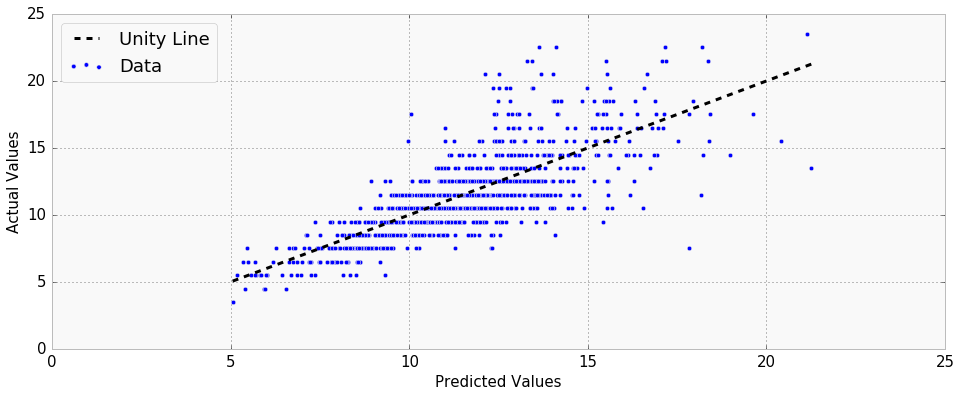

RMSE Test = 2.00534662332
RMSE Train = 2.05368281057


In [209]:
Y_pred = model.predict(np.array(x_test[feature_names]), verbose = 0)
Y_predTr = model.predict(np.array(x_train[feature_names]), verbose = 0)

eval_regressor(Y_pred, Y_test['Age'], Y_predTr, Y_train['Age'])

At 68.97% classification accuracy and 2.01 RMSE for regression accuracy, this is the best model yet.  Because of the large number of hyperparameters and architectures neural networks have, with the right network setup this percentage could increase even further.  In addition, neural networks can be sensitive to how inputs are encoded, and fine-tuning this encoding can yield additional increases in performance.  However, this small network took about 5 minutes to run on a personal computer, compared to the other algorithms that have so far taken just seconds and produced comparable accuracy.  So the performance increase was very costly in terms of computational resources.

# Conclusions

In this two-part tutorial we briefly covered a broad array of supervised learning methods - that is, methods that can learn to classify data by fitting a training set with features and class labels or value labels, and can generate predictions for new, unlabeled data based on input features.  The methods were only illustrated at a surface level - many of these algorithms can be improved through optimization of hyperparameters or modifications to the algorithms themselves.

Overall, differences in prediction performance for our data set were generally minimal.  Likely only big differences such as between Naive Bayes and Neural Networks are real differences, while smaller differences are likely to be driven by noise.  In practice with larger data sets with more complexity in structure and a higher dimensional feature space, algorithm selection can be critical and can make a much bigger difference in performance than what we have seen in this overview.